In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset_dict.json
/kaggle/input/train/state.json
/kaggle/input/train/dataset_info.json
/kaggle/input/train/data-00000-of-00001.arrow


Dataset Description:
                                               input  \
0  What is the relationship between very low Mg2+...   
1  What leads to genitourinary syndrome of menopa...   
2  What does low REM sleep latency and experienci...   
3  What are some possible causes of low PTH and h...   
4  How does the level of anti-müllerian hormone r...   

                                              output  \
0  Very low Mg2+ levels correspond to low PTH lev...   
1  Low estradiol production leads to genitourinar...   
2  Low REM sleep latency and experiencing halluci...   
3  PTH-independent hypercalcemia, which can be ca...   
4  The level of anti-müllerian hormone is directl...   

                       instruction  
0  Answer this question truthfully  
1  Answer this question truthfully  
2  Answer this question truthfully  
3  Answer this question truthfully  
4  Answer this question truthfully  
Number of documents: 33955
Vocabulary size: 29179
Average document length: 14.55897

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


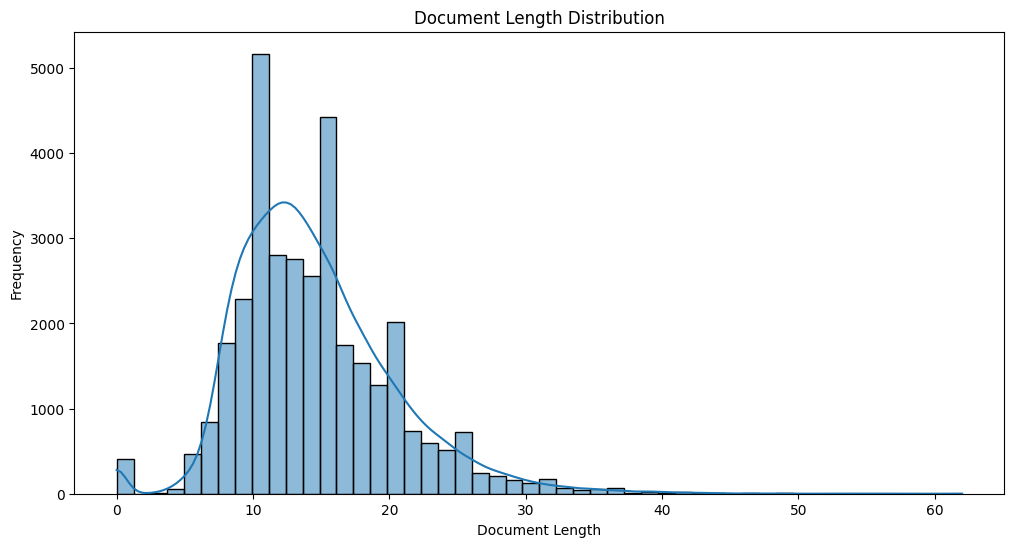

In [2]:
import pandas as pd
from datasets import Dataset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

# Load the dataset from the saved arrow file
dataset = Dataset.from_file('/kaggle/input/train/data-00000-of-00001.arrow')

# Convert to Pandas DataFrame for analysis
df = dataset.to_pandas()

# Describe the dataset
print("Dataset Description:")
print(df.head()) 

# Column names
text_column = 'input'

# Number of documents
num_documents = len(df)
print(f"Number of documents: {num_documents}")

# Document length (number of words per document)
df['doc_length'] = df[text_column].apply(lambda x: len(x.split()))

# Vocabulary size
all_words = [word for text in df[text_column].dropna() for word in text.split()]
vocab = Counter(all_words)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Average document length
average_doc_length = df['doc_length'].mean()
print(f"Average document length: {average_doc_length}")

# Visualize document length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['doc_length'], bins=50, kde=True)
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

# Optional: Save the figure
# plt.savefig('/Users/icon1c/Documents/Semester 2/Natural Language Processing/NLP-Polimi-Project/Practice Models/Rishabh/dataset/document_length_distribution.png')


In [3]:
pip install scikit-learn;

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


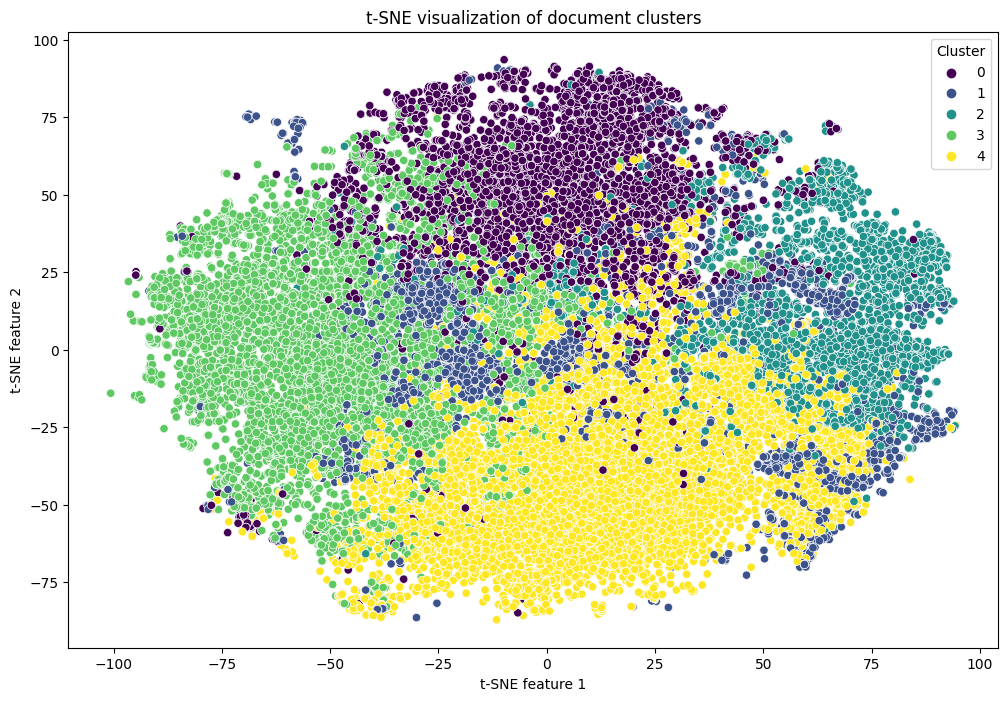

In [4]:
from datasets import load_dataset
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'input' is the column with text data
texts = (df['input'] + " " + df["output"]).apply(lambda x: x.split()).tolist()

# Train Word2Vec model
model = Word2Vec(sentences=texts, vector_size=100, window=5, min_count=1, workers=4)

# Generate document embeddings by averaging word vectors
def document_vector(doc):
    # Remove out-of-vocabulary words and get the mean of the word vectors
    return np.mean([model.wv[word] for word in doc if word in model.wv.key_to_index], axis=0)

# Create document embeddings (you might need to exclude empty documents)
doc_embeddings = np.array([document_vector(doc) for doc in texts if len(doc) > 0])

# Clustering with K-means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(doc_embeddings)

# Dimensionality reduction with t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(doc_embeddings)

# Plotting the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=clusters, palette='viridis')
plt.title('t-SNE visualization of document clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend(loc='best', title='Cluster')
plt.show()


In [5]:
# Keyword Indexing: Create a simple inverted index for keyword search
from collections import defaultdict

# Create an inverted index mapping keyword to document index
inverted_index = defaultdict(list)

for idx, doc in enumerate(texts):
    for word in set(doc):
        inverted_index[word].append(idx)

# Function to perform keyword search
def search_keyword(keyword):
    return [df.iloc[idx]['input'] for idx in inverted_index[keyword]]

# Example usage: search for documents containing the word 'medicine'
search_results = search_keyword('medicine')
print(search_results[:10])  # Display the first 10 results

['What is the use of α antagonists (such as phentolamine) in medicine and what condition can they be used to treat?', 'What is dextromethorphan, and how is it used in medicine?', 'What is the Still technique?', 'What is PDGF, and where is it secreted from?', 'What is a commonly used term in respiratory medicine to describe the characteristic sound associated with croup, which is caused by a parainfluenza infection and affects the larynx, trachea, and bronchi?', 'What are the three components that make up the Glasgow Coma Scale (GCS)?', 'What can be calculated using the Henderson-Hasselbach equation with pH and PaCO2 as inputs?', "What is Lugol's iodine and how is it used to evoke the Wolff-Chaikoff effect?", 'Should a patient be allowed to try alternative or holistic medicine that is known to be safe?', 'What are the diagnostic methods used to diagnose cholecystitis, and what is cholecystitis?']


In [6]:
# Exploring Word Embeddings
print("Most similar to 'medicine':", model.wv.most_similar('medicine', topn=5))
print("Most similar to 'production':", model.wv.most_similar('production', topn=5))
print("Most similar to 'heart':", model.wv.most_similar('heart', topn=5))


# Perform vector arithmetic: (king - man + woman = queen)
try:
    print("pulmonary - lung + heart (King - Man + Woman analogy):", model.wv.most_similar(positive=['pulmonary', 'heart'], negative=['lung'],  topn=1))
except KeyError as e:
    print(e)

Most similar to 'medicine': [('ink', 0.7742263078689575), ('cholinomimetic', 0.7729795575141907), ('India', 0.7562586665153503), ('quick', 0.7432896494865417), ('Terbutaline', 0.7432425618171692)]
Most similar to 'production': [('release', 0.8603382110595703), ('activation', 0.7978953123092651), ('breakdown', 0.7866056561470032), ('activity', 0.7775583267211914), ('secretion', 0.7746701836585999)]
Most similar to 'heart': [('cardiac', 0.7389419078826904), ('pulmonary', 0.6624261140823364), ('thrive.', 0.6191638708114624), ('ventricular', 0.6169008612632751), ('kidney', 0.5906130075454712)]
pulmonary - lung + heart (King - Man + Woman analogy): [('ventricular', 0.6890984773635864)]


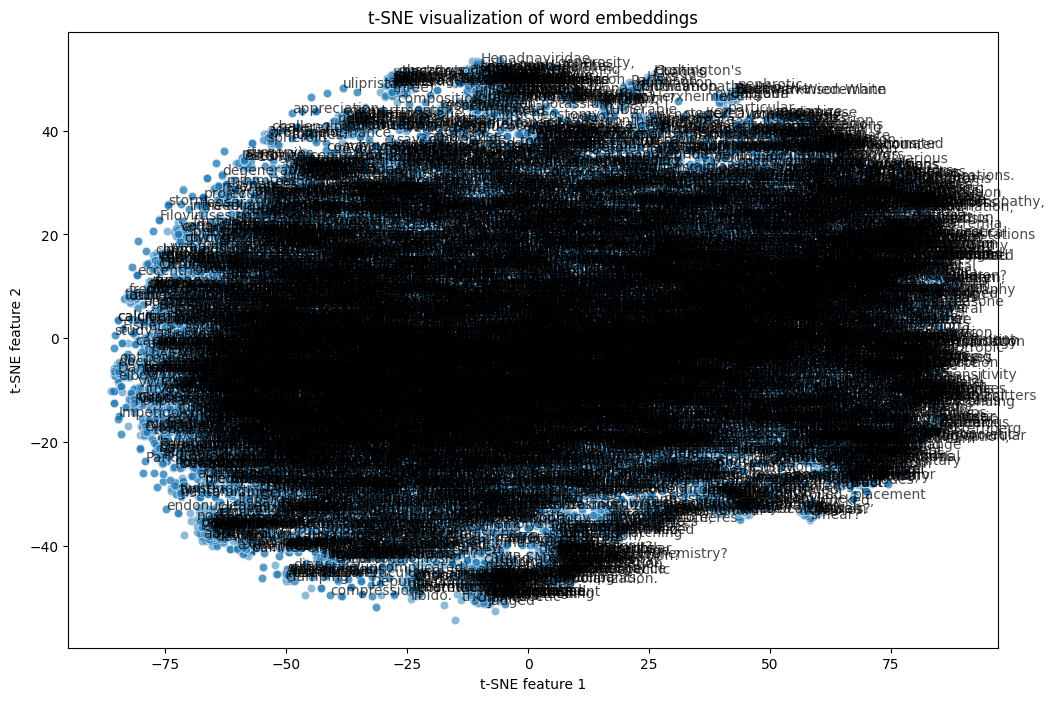

In [7]:
# Visualizing Word Embeddings using t-SNE
words = list(model.wv.index_to_key)
word_vectors = np.array([model.wv[word] for word in words])

# Dimensionality reduction with t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_reduced = tsne.fit_transform(word_vectors)

# Plotting the word embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(x=word_vectors_reduced[:, 0], y=word_vectors_reduced[:, 1], alpha=0.5)
plt.title('t-SNE visualization of word embeddings')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# Annotating a subset of words to keep the plot readable
for i, word in enumerate(words):
    if np.random.random() < 0.1:  # Annotate roughly 10% of the words
        plt.annotate(word, xy=(word_vectors_reduced[i, 0], word_vectors_reduced[i, 1]), alpha=0.7)

plt.show()

Most common words: [('the', 130726), ('of', 95365), ('is', 81622), ('and', 76028), ('to', 56983), ('a', 50349), ('in', 45262), ('that', 28862), ('can', 27672), ('What', 24358), ('with', 24131), ('for', 24056), ('are', 24053), ('as', 21380), ('or', 17270), ('which', 17099), ('by', 16003), ('be', 15078), ('The', 15007), ('may', 12692)]


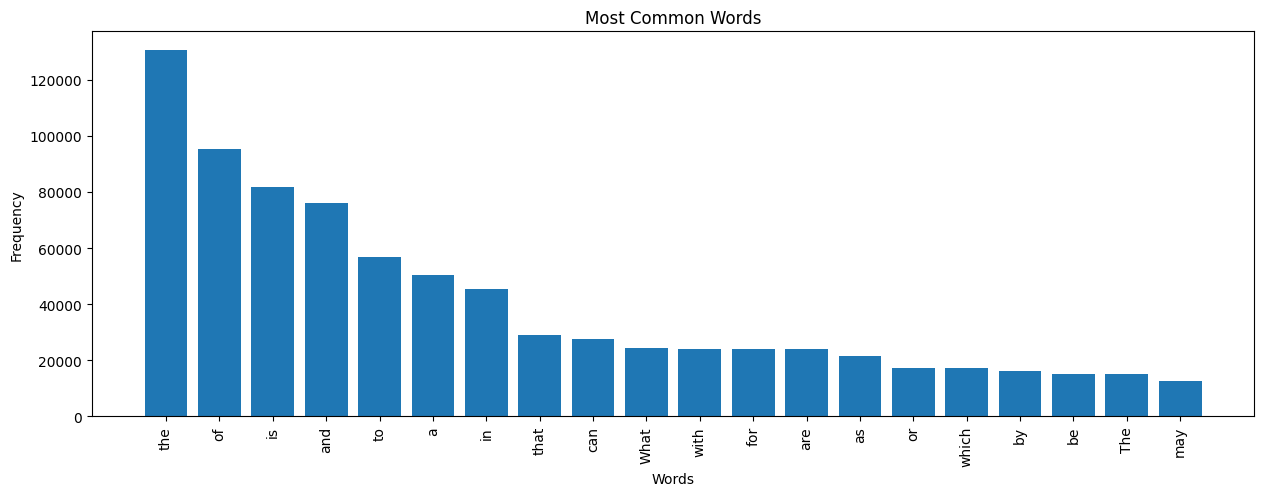

In [8]:
from collections import Counter

# Flatten the list of words in all documents
all_words = [word for text in texts for word in text]

# Calculate word frequencies
word_freq = Counter(all_words)

# Most common words
common_words = word_freq.most_common(20)

# Print the most common words
print("Most common words:", common_words)

# Plotting the most common words
plt.figure(figsize=(15, 5))
words, frequencies = zip(*common_words)
plt.bar(words, frequencies)
plt.title('Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the x labels to show them better
plt.show()

In [9]:
pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


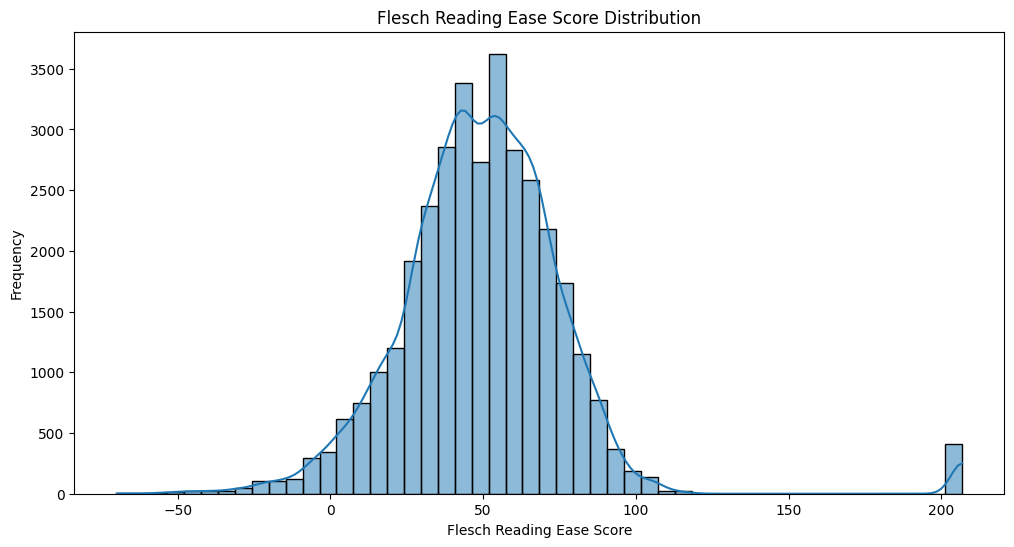

In [10]:
import textstat

# Calculate Flesch Reading Ease scores for each document
df['flesch_reading_ease'] = df['input'].apply(textstat.flesch_reading_ease)

# Visualize the distribution of Flesch Reading Ease scores
plt.figure(figsize=(12, 6))
sns.histplot(df['flesch_reading_ease'], bins=50, kde=True)
plt.title('Flesch Reading Ease Score Distribution')
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Frequency')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


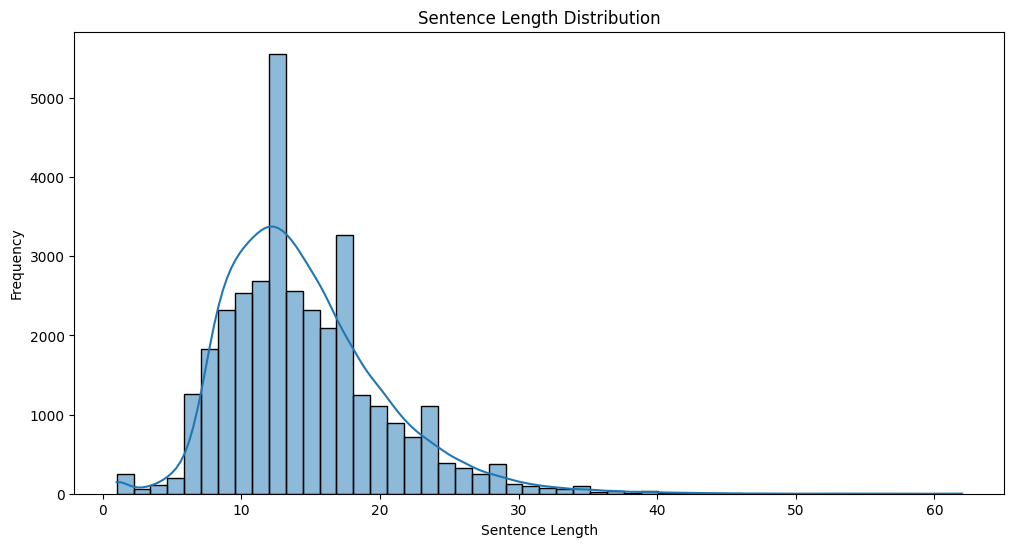

In [11]:
# Function to calculate the length of each sentence in a document
def sentence_lengths(text):
    sentences = text.split('.')  # Assuming sentences are separated by periods
    return [len(sentence.split()) for sentence in sentences]

# Calculate sentence lengths for each document
df['sentence_lengths'] = df['input'].apply(sentence_lengths)

# Flatten the list of sentence lengths to get overall distribution
all_sentence_lengths = [length for lengths in df['sentence_lengths'] for length in lengths if length > 0]

# Visualize the distribution of sentence lengths
plt.figure(figsize=(12, 6))
sns.histplot(all_sentence_lengths, bins=50, kde=True)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

Import the dataset and convert to dataframe

First we start by vectorizing our flashcards. 
For the topic models we are using a simple count vectorizer.

We are also using both the question and the answer as our documents, since they are inherently linked.

After removing stop words, we can see that our vocabulary is approximately 11000 words long.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

q_and_a = df['input'] + df['output']
print(q_and_a)

vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_documents_train = vectorizer.fit_transform(q_and_a)

vocab = vectorizer.get_feature_names_out()
len(vocab)

0        What is the relationship between very low Mg2+...
1        What leads to genitourinary syndrome of menopa...
2        What does low REM sleep latency and experienci...
3        What are some possible causes of low PTH and h...
4        How does the level of anti-müllerian hormone r...
                               ...                        
33950    At what age does bed wetting (enuresis) become...
33951                                                     
33952                                                     
33953                                                     
33954                                                     
Length: 33955, dtype: object


10953

To generate our topics we are using LDA with 30 components.
Therefore in the end we'll have 30 topics.

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=30, verbose=1, learning_method='online', max_iter=30, random_state=42)
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(learning_method='online', max_iter=30,
                          n_components=30, random_state=42, verbose=1)

Let's now see some of the keywords for our topics.

Some of these topics are clearer than others.
A few examples include:
- Topic 4: Lungs and respiratory system
- Topic 7: Bacterial infections
- Topic 13: Pregnancy
- Topic 15: Heart diseases
- Topic 19: Cancer and tumors
- Topic 20: Skin conditions
- Topic 21: Viruses

In [14]:
import numpy as np

# list all topics with their most frequent terms
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [nerve, brain, lesions, movement, motor, muscles, lesion, result, neurons, head]
Topic 2:	 [injury, likely, child, months, considered, long, anxiety, hand, testing, method]
Topic 3:	 [syndrome, diabetes, associated, insulin, characterized, condition, ovarian, eye, substances, clinical]
Topic 4:	 [lung, respiratory, pulmonary, lungs, lower, oxygen, chest, breathing, air, upper]
Topic 5:	 [cells, cell, liver, body, bone, immune, role, important, response, factor]
Topic 6:	 [muscle, acid, synthesis, spinal, cord, weakness, responsible, vaccine, structure, neck]
Topic 7:	 [infections, bacteria, infection, antibiotics, bacterial, class, used, type, drugs, treat]
Topic 8:	 [risk, increased, kidney, increase, renal, decreased, associated, developing, kidneys, acid]
Topic 9:	 [non, mechanism, negative, level, action, peripheral, venous, hepatic, limb, agents]
Topic 10:	 [symptoms, typically, pain, cause, condition, treatment, include, medical, diagnosis, fever]
Topic 11:	 [arthritis,

In [15]:
# Display topics for a question

i = 3178
doc = df["input"][i]

doc_vec = vectorizer.transform([doc])[0]
topic_vec = lda.transform(doc_vec)[0]

print(doc)
print(df['output'][i])

sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

What is the effect of Mafenide on an eschar and what is its potential side effect?
Mafenide is a medication that is used to treat burns. It has the ability to penetrate an eschar, which is the hard, blackened tissue that forms over a burn. This allows the medication to reach the underlying tissue and prevent infection. However, one potential side effect of Mafenide is that it can be quite painful when applied to the burn site. This is because the medication is acidic and can cause a burning sensation. Despite this side effect, Mafenide is still considered an effective treatment for burns and is commonly used in hospitals and burn centers around the world.
60.7% Topic 13: effects potential use effect possible cause taking specifically seizures drugs
20.7% Topic 21: patient treatment surgery effective provider surgical life patients necessary size


Now we want to visualize clusters. For that we are reducing the dimensionality of the vectors via TSNE to 2 dimensions.

In [16]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(n_components=2).fit_transform(lda.transform(vector_documents_train))
tsne_embedding.shape

(33955, 2)

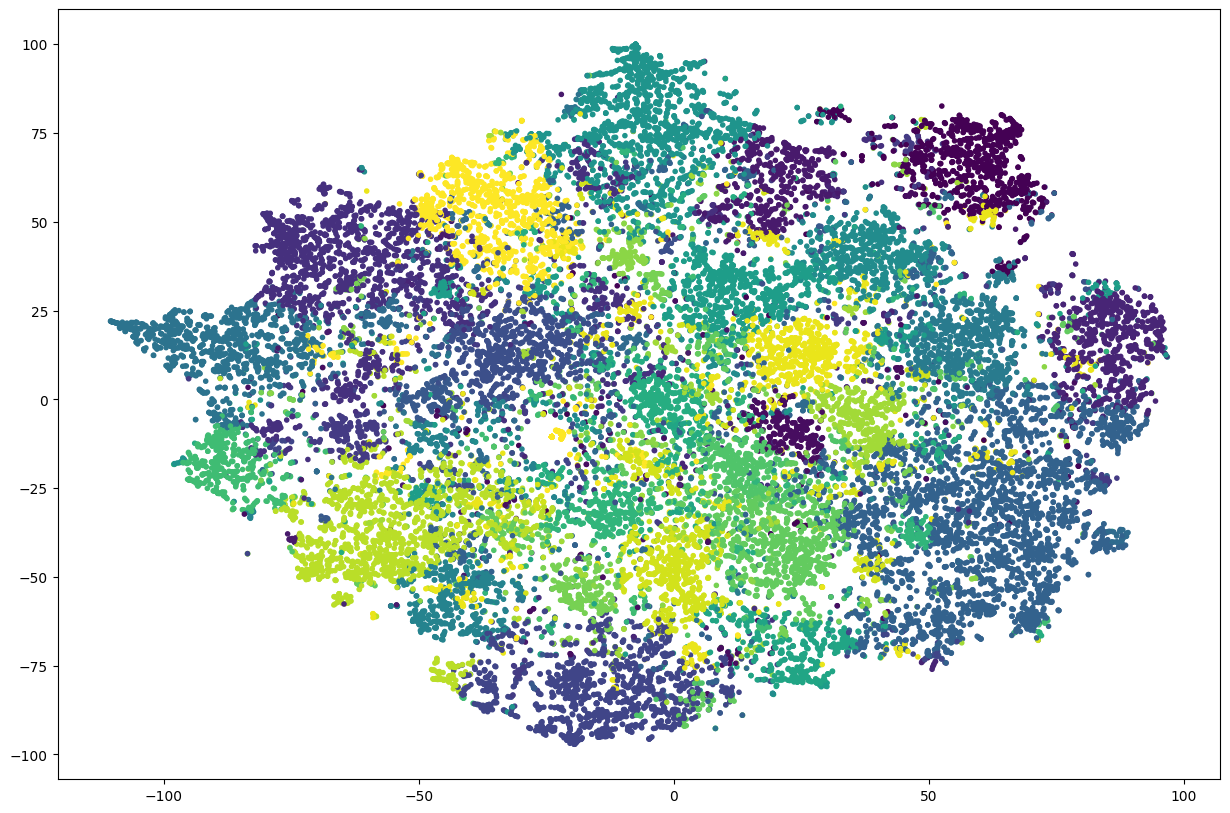

In [17]:
from matplotlib import pyplot as plt

[x, y] = np.transpose(tsne_embedding)

# assign documents the topic with the highest percentage
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(vector_documents_train)]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.scatter(x, y, c=freq_topic, marker='.')

In [18]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 7.8 MB/s eta 0:00:00
Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819466 sha256=ed59a5e090bd59c4081c9f2a6b0a4a093bee81ea8adc6725a797523e8e71aa18
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cytho

In [19]:
from bertopic import BERTopic
bert_topic_model = BERTopic()
topics, probs = bert_topic_model.fit_transform(q_and_a)

2024-05-18 16:03:40.621284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 16:03:40.621492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 16:03:40.804400: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already b

In [20]:
bert_topic_model.get_topic_info()

Topic  Count                                               Name  \
0       -1   9472                                -1_what_the_for_are   
1        0    414           0_platelet_clotting_coagulation_warfarin   
2        1    402                                              1____   
3        2    223      2_pth_calcium_parathyroid_hyperparathyroidism   
4        3    192                    3_gram_algorithm_bacteria_stain   
..     ...    ...                                                ...   
765    764     10         764_mumps_orchitis_parotitis_paramyxovirus   
766    765     10                 765_restless_leg_dopamine_agonists   
767    766     10                    766_leptin_ghrelin_appetite_pyy   
768    767     10             767_methacholine_challenge_asthma_copd   
769    768     10  768_holoprosencephaly_hydantoin_cleft_microcep...   

                                        Representation  \
0     [what, the, for, are, is, of, and, in, to, with]   
1    [platelet, clotting, coagulation, warfarin, pl...   
2                                 [, , , , , , , , , ]   
3    [pth, calcium, parathyroid, hyperparathyroidis...   
4    [gram, algorithm, bacteria, stain, positive, b...   
..                                                 ...   
765  [mumps, orchitis, parotitis, paramyxovirus, ma...   
766  [restless, leg, dopamine, agonists, legs, synd...   
767  [leptin, ghrelin, appetite, pyy, praderwilli, ...   
768  [methacholine, challenge, asthma, copd, spirom...   
769  [holoprosencephaly, hydantoin, cleft, microcep...   

                                   Representative_Docs  
0    [What is the recommended next step in manageme...  
1    [What are the typical laboratory findings in p...  
2                                               [, , ]  
3    [What is the relationship between chronic hypo...  
4    [How is Proteus classified based on its Gram s...  
..                                                 ...  
765  [Besides bilateral parotitis, what are some ot...  
766  [In the management of restless leg syndrome, w...  
767  [What is the relationship between Prader-Willi...  
768  [What are some tests that may aid in the clini...  
769  [In a newborn with microcephaly, hirsutism, ph...  

[770 rows x 5 columns]

In [21]:
pip install spacy textstat

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import ngrams
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from textstat import flesch_reading_ease
from datasets import load_dataset
import spacy

In [23]:
# Basic Information
print("Basic Information about the Dataset:")
print(f"Total Documents: {len(df)}")
print(f"Average document length (words): {df['input'].apply(lambda x: len(x.split())).mean()}")

Basic Information about the Dataset:
Total Documents: 33955
Average document length (words): 14.558975114121631


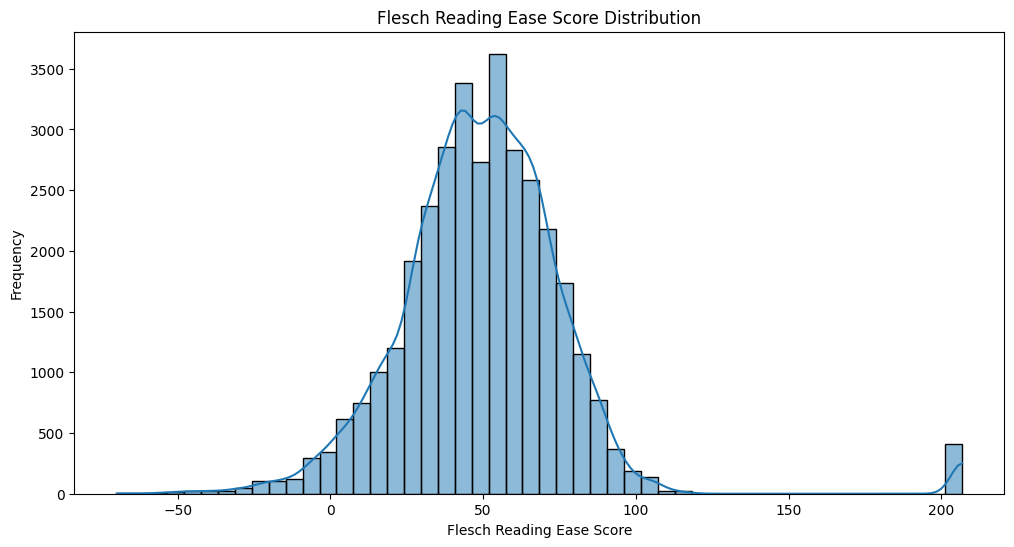

In [24]:
# Text Readability: Flesch Reading Ease
df['flesch_reading_ease'] = df['input'].apply(flesch_reading_ease)
plt.figure(figsize=(12, 6))
sns.histplot(df['flesch_reading_ease'], bins=50, kde=True)
plt.title('Flesch Reading Ease Score Distribution')
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Frequency')
plt.show()

In [25]:
# N-grams and Collocations
def get_top_ngrams(corpus, n=None, top_k=20):
    vec = TfidfVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

In [26]:
# Top bigrams and trigrams
top_bigrams = get_top_ngrams(df['input'], n=2)
top_trigrams = get_top_ngrams(df['input'], n=3)
print("Top Bigrams:", top_bigrams)
print("Top Trigrams:", top_trigrams)

Top Bigrams: [('commonly associated', 110.5488227549751), ('recommended treatment', 102.52126117839677), ('medical condition', 100.2594067897726), ('used treat', 99.99531431485302), ('common cause', 84.92869819387322), ('symptoms associated', 70.23776182624107), ('mechanism action', 62.495341567483294), ('common symptoms', 59.8878338763358), ('term used', 58.10312316286337), ('commonly used', 55.654829548639086), ('does affect', 53.920173035669784), ('condition suggested', 50.54076976452948), ('treatment options', 46.397244029502765), ('commonly affected', 45.97204932453484), ('likely diagnosis', 45.41281623825772), ('possible diagnosis', 44.33640907534805), ('adverse effect', 43.78851869618), ('potential consequence', 43.52427208432963), ('recommended step', 42.788468106146226), ('increased risk', 41.72963288648772)]
Top Trigrams: [('recommended step management', 32.060393208017956), ('condition suggested presence', 31.29602428329383), ('common symptoms associated', 23.116156580361835

In [27]:
pip install --upgrade certifi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [28]:
import os
import ssl
import certifi

# Set the environment variable for SSL certificate file
os.environ['SSL_CERT_FILE'] = certifi.where()

# Now, create a new default HTTPS context which uses this certificate
ssl._create_default_https_context = ssl.create_default_context

In [29]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')  # This is for the word_tokenize function

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
# Part-of-Speech Tagging and Frequency Distribution
df['pos_tags'] = df['input'].apply(lambda x: pos_tag(word_tokenize(x)))
pos_counts = Counter([pos for sublist in df['pos_tags'] for _, pos in sublist])
print("POS Tag Counts:", pos_counts)

POS Tag Counts: Counter({'NN': 108079, 'IN': 64880, 'JJ': 55339, 'DT': 47625, '.': 34002, 'VBZ': 33981, 'WP': 30304, 'NNS': 27994, 'NNP': 18814, 'CC': 16440, 'VBN': 14600, ',': 13140, 'VB': 12744, 'VBP': 11739, 'WDT': 8442, 'TO': 7578, 'RB': 6085, 'WRB': 5860, 'VBG': 5278, 'PRP': 4830, 'MD': 4809, ')': 3508, '(': 3499, 'CD': 2838, 'VBD': 2054, 'PRP$': 1384, 'RBS': 1245, 'POS': 610, 'JJR': 574, "''": 479, '``': 462, 'JJS': 402, 'RBR': 256, ':': 203, 'RP': 197, 'EX': 151, 'FW': 97, 'NNPS': 76, 'PDT': 39, 'WP$': 31, '$': 22, 'UH': 5})


In [31]:
!python3 -m spacy download en_core_web_sm

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.3 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [32]:
import spacy

# Load the installed spaCy model
nlp = spacy.load("en_core_web_sm")

# Proceed with your NER task
df['entities'] = df['input'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])
entity_counts = Counter([entity for sublist in df['entities'] for entity, _ in sublist])
print("Entity counts:", entity_counts)

Entity counts: Counter({'two': 472, 'first': 402, 'one': 283, 'three': 187, 'second': 101, 'CNS': 96, 'ECG': 89, 'RNA': 80, 'ADH': 77, 'PTH': 75, 'HPV': 65, 'IV': 63, 'CT': 62, 'GI': 61, 'Streptococcus': 59, '1': 59, 'O2': 58, 'third': 53, 'II': 52, 'Plasmodium': 50, 'CSF': 50, 'CMV': 50, 'Staphylococcus': 48, 'Chlamydia': 47, '2': 47, 'hematuria': 46, 'Neisseria': 45, 'Hodgkin': 42, 'HSV': 42, 'ACE': 41, 'TSH': 40, 'AV': 39, 'Clostridium': 39, 'Gram': 39, 'HAART': 39, 'four': 37, 'gram': 37, 'Crohn': 37, 'SIADH': 36, 'NSAIDs': 36, 'Cushing': 34, 'Rickettsia': 34, 'hernia': 34, 'B12': 33, 'EBV': 32, 'BUN': 32, 'the United States': 31, 'HLA': 31, 'Lyme': 31, 'dysphagia': 30, 'CXR': 30, '3': 30, '2nd': 30, 'REM': 29, 'AFP': 29, 'HBV': 29, 'FSH': 28, 'BPH': 28, 'Haemophilus': 28, 'prolactin': 28, 'Entamoeba': 27, 'Wilson': 27, 'Huntington': 27, 'Langerhans': 27, 'atresia': 27, '5': 26, 'Henle': 26, 'LH': 26, 'T3': 25, 'Guillain-Barré': 25, 'Graves': 25, 'Pap': 25, 'GERD': 25, 'T4': 24, 'S

In [33]:
# TF-IDF Analysis
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_result = tfidf.fit_transform(df['input'])
tfidf_df = pd.DataFrame(tfidf_result.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.columns = [str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

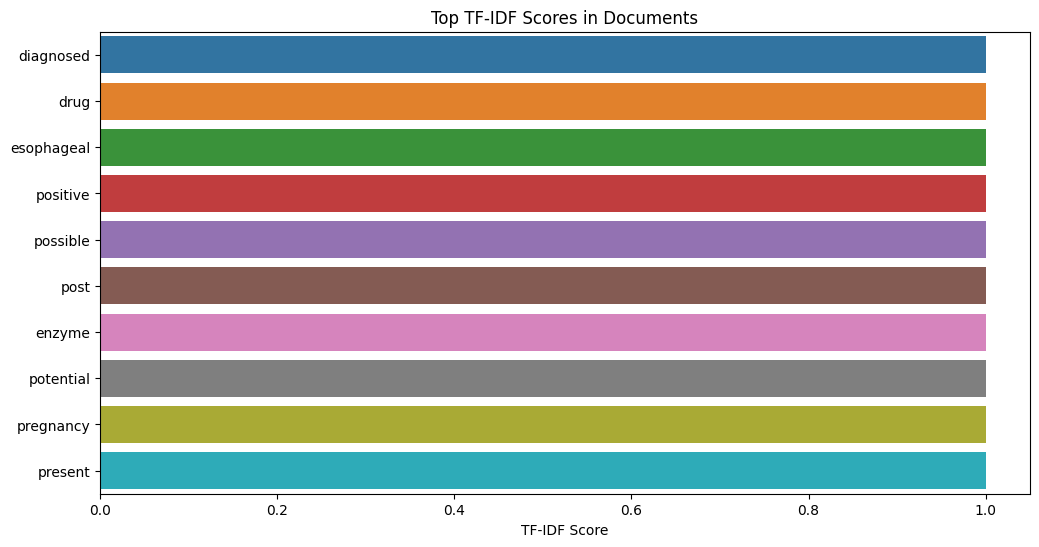

In [34]:
# Visualizing the TF-IDF of the top 10 words
top_n_tfidf = tfidf_df.max().sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 6))
sns.barplot(x=top_n_tfidf.values, y=top_n_tfidf.index)
plt.title('Top TF-IDF Scores in Documents')
plt.xlabel('TF-IDF Score')
plt.show()

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from nltk import FreqDist

In [36]:
# Visualization Setup
plt.style.use('ggplot')

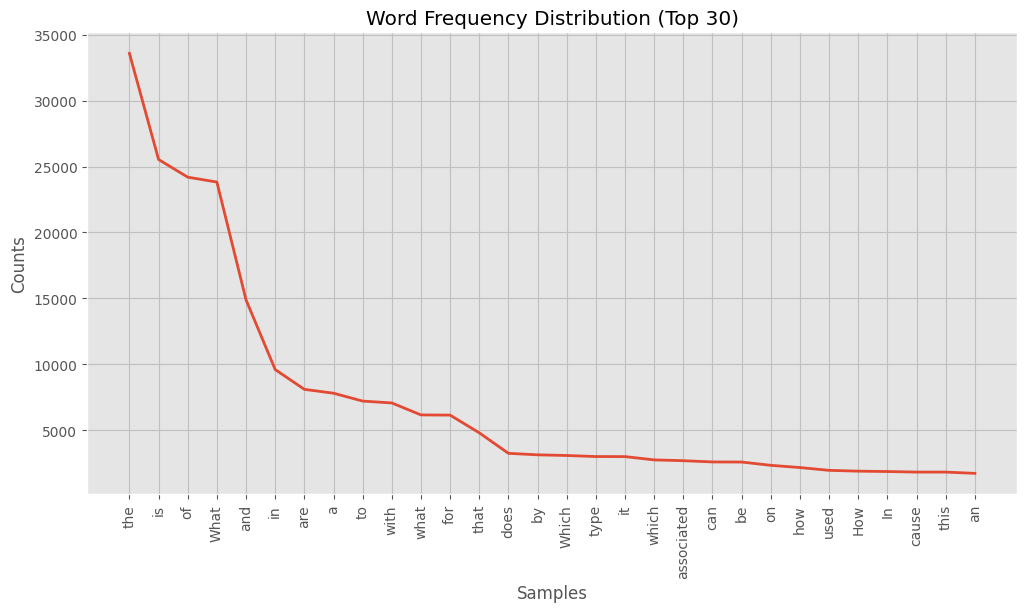

In [37]:
# Word Frequency Distribution
all_words = [word for text in df['input'].apply(lambda x: x.split()) for word in text]
freq_dist = FreqDist(all_words)
plt.figure(figsize=(12, 6))
freq_dist.plot(30, cumulative=False, title='Word Frequency Distribution (Top 30)')

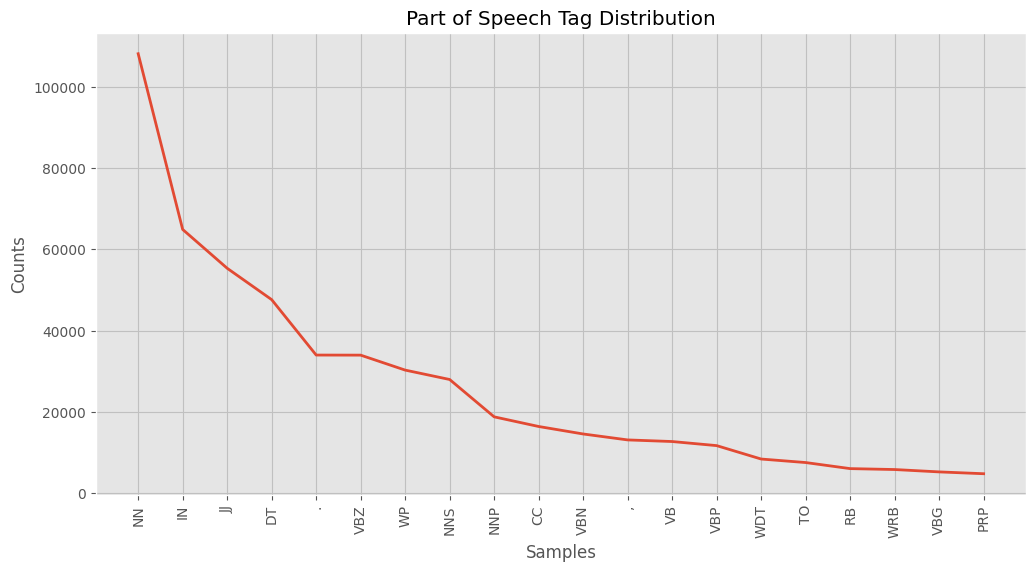

In [38]:
# POS Tag Distribution
pos_tags = [pos for sublist in df['pos_tags'] for _, pos in sublist]
pos_freq_dist = FreqDist(pos_tags)
plt.figure(figsize=(12, 6))
pos_freq_dist.plot(20, title='Part of Speech Tag Distribution')

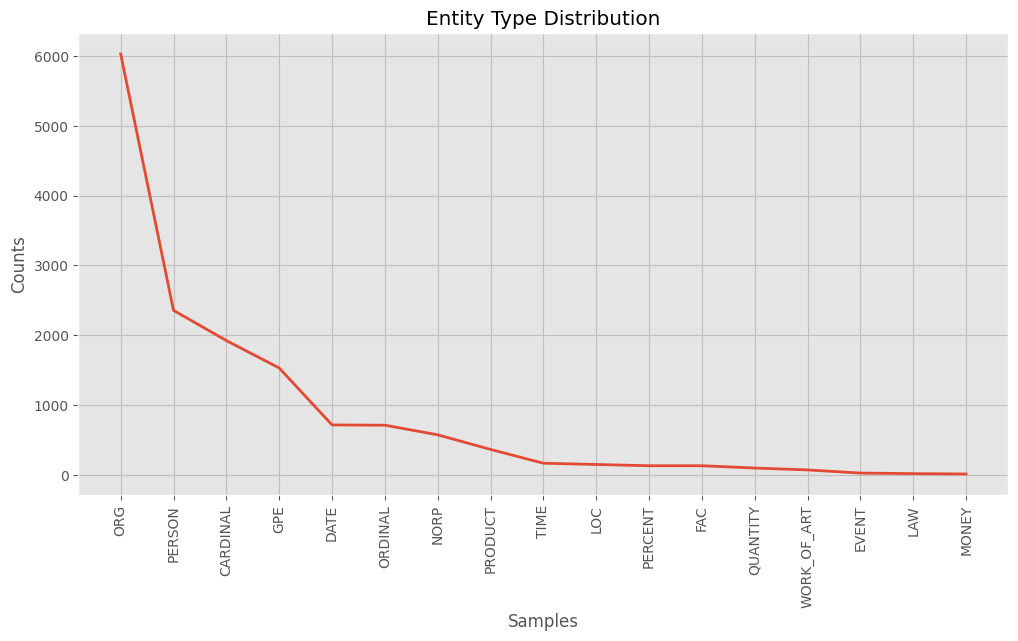

In [39]:
# Entity Type Distribution from spaCy
entity_types = [label for sublist in df['entities'] for _, label in sublist]
entity_freq_dist = FreqDist(entity_types)
plt.figure(figsize=(12, 6))
entity_freq_dist.plot(20, title='Entity Type Distribution')

In [40]:
# TSNE Visualization of TF-IDF Vectors
tfidf_array = tfidf_result.toarray() 
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(tfidf_array)

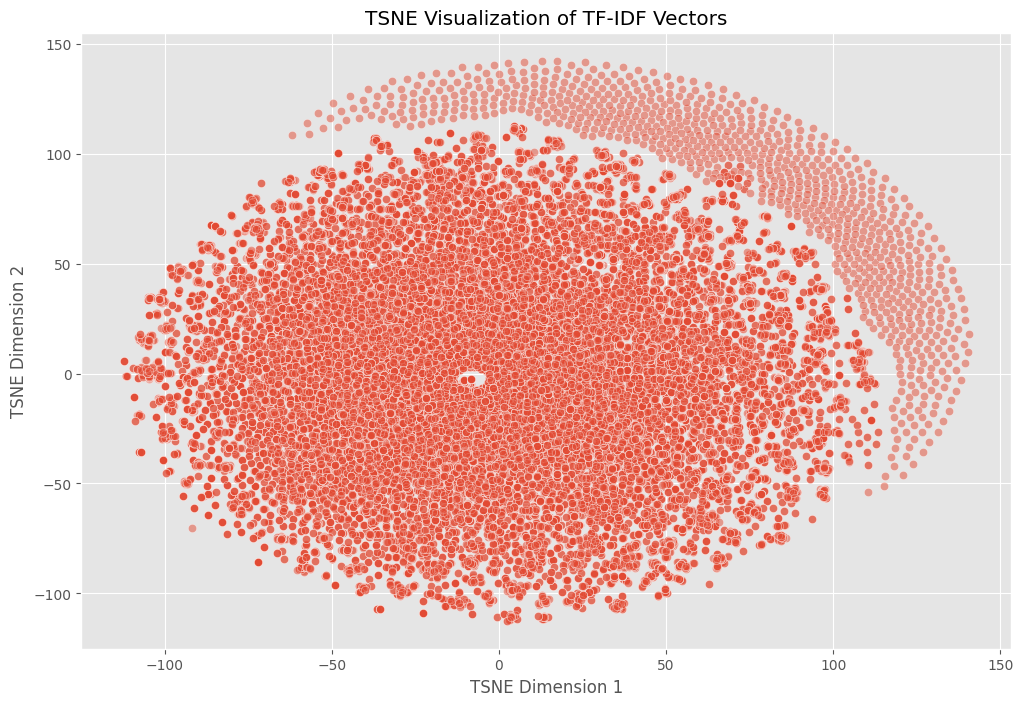

In [41]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], alpha=0.5)
plt.title('TSNE Visualization of TF-IDF Vectors')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')
plt.show()

In [42]:
# Heatmap of Top TF-IDF Features Across Documents
# Select top 10 TF-IDF features for visualization
top_n_features = tfidf_df.columns.tolist()[:10]
top_features_df = df[top_n_features]

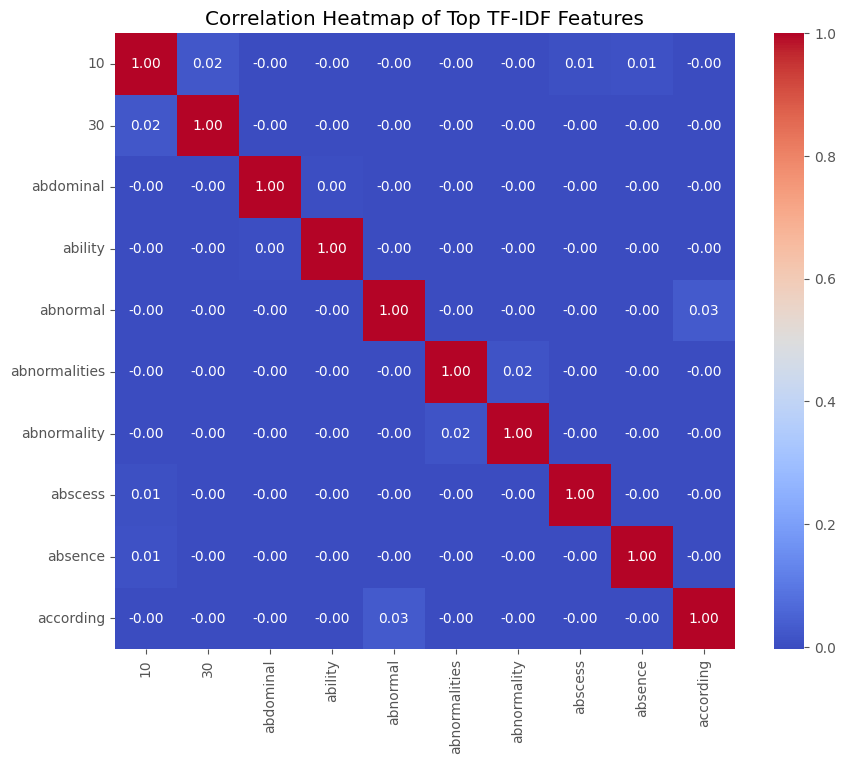

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(top_features_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Top TF-IDF Features')
plt.show()

In [44]:
pip install plotly

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [45]:
# Interactive Boxplot of Flesch Reading Ease by Entity Type
import plotly.express as px
df['max_entity_type'] = df['entities'].apply(lambda x: max(x, key=lambda y: y[1])[1] if x else 'None')

In [46]:
fig = px.box(df, x='max_entity_type', y='flesch_reading_ease', points="all",
             title='Boxplot of Flesch Reading Ease Scores by Entity Type')
fig.show()

In [47]:
# Barplot of Average Document Length by Top Entities
top_entities = [entity for entity, _ in entity_counts.most_common(5)]
df['doc_length'] = df['input'].apply(lambda x: len(x.split()))
average_length_by_entity = {entity: df[df['input'].str.contains(entity)]['doc_length'].mean() for entity in top_entities}

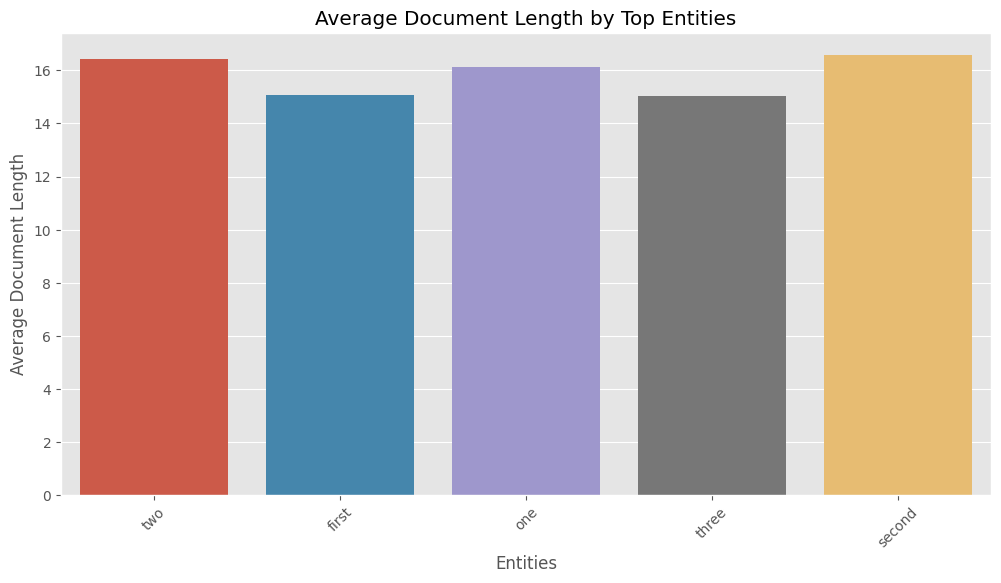

In [48]:
plt.figure(figsize=(12, 6))
sns.barplot(x=list(average_length_by_entity.keys()), y=list(average_length_by_entity.values()))
plt.title('Average Document Length by Top Entities')
plt.xlabel('Entities')
plt.ylabel('Average Document Length')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()